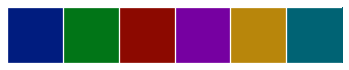

In [1]:
%matplotlib inline
import seaborn 
seaborn.set(
    context="talk", palette=seaborn.color_palette('dark')
)

from matplotlib import pylab
seaborn.palplot(
    seaborn.color_palette("dark")
)

In [2]:
import copy
import pathlib
import numpy as np
import pandas


from matplotlib import pylab

from multiprocessing import Pool

from scipy import signal

from kaskady2.analyze.fits import * 
from kaskady2.analyze.profile import *
from kaskady2.analyze.profile_fits import *
from kaskady2.analyze.fluctuation_treshold import *
from kaskady2.loader.reader import CascadeSetLoader

import os


In [3]:
fits_dir = pathlib.Path("/tmp/fits-fluc-final")
os.makedirs(str(fits_dir), exist_ok=True)

In [4]:
class FlucFitPerformer(FitPerformer):
    
    def __init__(self, loader, param): 
        super().__init__(copy.copy(loader.config))
        self.loader=loader
        self.param=param
        self.context.A = "{:.2f}".format(param)
        
    def get_fit_data(self) -> FitData:
        geometry = self.loader.main_geometry
        fluc = FluctuationCalculation.from_geometry(
            geometry, self.param
        )        
        return FluctuationFitData(fluc) 

    def get_fit_function(self) -> FitFunction:
        return WeibullFunc()
    



def do_fit(args): 
    loader, params = args
    

    def single_fit(param): 
        performer = FlucFitPerformer(loader, param)
        result = performer.do_fit()
        
        data = result.fit_data
        config = copy.copy(result.context)
        
        try: 
            pylab.clf()

            pylab.plot(
              data.xdata, 
              data.ydata, 
              label="Fluctuation"
            )

            pylab.plot(
                data.xdata, result.fitted_ydata, 
                label="Fit using weibull function"
            )

            pylab.xlabel("Cascade depth [rad. len.]")
            pylab.ylabel("Fluctuation [arb. unit.]")

            pylab.title(
                "$E_\gamma={config.run_info.energy_mev}MeV$  "  
                "$E_{{c.o.}}={config.ecuts.energy_mev}MeV$  "
                "$A={A}$  $N_{{inc}}={config.run_info.incidents}$".format(
                    config=config, A=param
                ), 
                fontsize=12)
            pylab.suptitle(
                "Fluctuation for cascade in {config.material.name_pretty}".format(config=config), fontsize=18
            )

            pylab.ylim(1E-5, 1.1*np.max(data.ydata))
            pylab.legend()
            pylab.savefig(str(fits_dir / "{}.png".format("-".join((map(str, (
              param,config.run_info.energy_mev , config.material.name, config.ecuts.energy_mev)))
            ))), dpi=150)       
            pylab.yscale('log')
            pylab.savefig(str(fits_dir / "{}-log.png".format("-".join((map(str, (
              param,config.run_info.energy_mev , config.material.name, config.ecuts.energy_mev)))
            ))), dpi=150) 
        except: 
            result.context.plot_error = True
        
        
        return result 
    
    return [
      single_fit(param) for param in params
    ]
    
        
        
    

In [5]:
cascades = CascadeSetLoader.find_cascades(
  pathlib.Path('/home/jb/kaskady-data/g4-production')    
)
geometry = cascades[-1].main_geometry


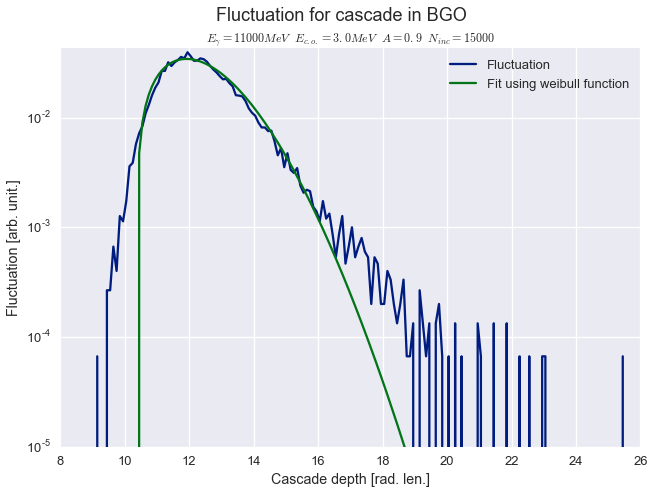

In [6]:
example_res = do_fit((cascades[0], [0.6, 0.75, 0.9]))

In [7]:
# example_res

In [8]:
pool = Pool(processes=9, maxtasksperchild=1)    
result = pool.map_async(do_fit, [(c, [0.6, 0.75, 0.9]) for c in cascades])
result.wait(timeout=600)
results = result.get()

/home/jb/programs/kaskady2.0/kaskady2/analyze/fluctuation_treshold/fits.py:56: RuntimeWarning: invalid value encountered in power
  (k / lambda_par) * (x / lambda_par) ** (k - 1) * np.exp(-(x / lambda_par)**k)
/home/jb/programs/kaskady2.0/kaskady2/analyze/fluctuation_treshold/fits.py:56: RuntimeWarning: invalid value encountered in power
  (k / lambda_par) * (x / lambda_par) ** (k - 1) * np.exp(-(x / lambda_par)**k)
/home/jb/programs/kaskady2.0/kaskady2/analyze/fluctuation_treshold/fits.py:56: RuntimeWarning: invalid value encountered in power
  (k / lambda_par) * (x / lambda_par) ** (k - 1) * np.exp(-(x / lambda_par)**k)
/home/jb/programs/kaskady2.0/kaskady2/analyze/fluctuation_treshold/fits.py:56: RuntimeWarning: invalid value encountered in power
  (k / lambda_par) * (x / lambda_par) ** (k - 1) * np.exp(-(x / lambda_par)**k)
/home/jb/programs/kaskady2.0/kaskady2/analyze/fluctuation_treshold/fits.py:56: RuntimeWarning: invalid value encountered in power
  (k / lambda_par) * (x / lamb

In [19]:
results = result.get()

AttributeError: 'list' object has no attribute 'get'

In [20]:
{r[0].context.A for r in results}

{'0.60'}

In [11]:
fsm = FitSetManager(
    index_attrs=('A', 'material', 'ecuts_kev', 'energy_mev'), 
    expected_params=['lambda', 'k', 'b']
)
fsm.context_attrs_to_extract['A'] = 'A'
#fsm.make_frame(keep_data=True)

In [12]:
for r in results: 
    fsm.add_results(r)

In [13]:
fsm.make_frame()

/home/jb/programs/kaskady2.0/kaskady2/analyze/fits/helpers.py:176: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  self.frame = table.sort(index_attrs).set_index(drop=False, keys=index_attrs)


In [14]:
fsm.save("/home/jb/kaskady-data/results/fluctuation.bin")

In [15]:
len(fsm.frame.fit_ok) - fsm.frame.fit_ok.sum()

0

In [16]:
table.to_excel("/tmp/fits-fluc/data.xls")

NameError: name 'table' is not defined

In [22]:
fsm.frame.A.unique()

array(['0.60', '0.75', '0.90'], dtype=object)